## Step 1: Import necessary libraries

In [1]:

# Packages needed generally
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np
from rasterio import mask

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs

## Step 2: Data access

In [2]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

## Step 3: Subset data to regoin of interest

In [3]:
# Search for the sea surface variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,CTRL,monthly,60.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-TE...
2,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
3,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [4]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 scenarios
variables = ["TEMP", "SALT", "O2"]
col_ocn = {}

for var in variables:
    col_ocn[f"{var}"] = col.search(
        frequency=["monthly"],
        component="ocn",
        variable=var,
        experiment=["20C", "RCP85"],
    )

print(col_ocn)

#Display the first few entries in the resulting data frame
col_ocn["TEMP"].df
col_ocn["SALT"].df
col_ocn["O2"].df

{'TEMP': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'SALT': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'O2': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>}


,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...


In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
#Lets create another for loop to iteratre over the col_ocn dictionary

dsets = {}
for var in variables:
    dsets[var] = col_ocn[var].to_dataset_dict(
        zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
    )
    print(f"\nDataset dictionary keys for {var}:\n {dsets[var].keys()}")



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/Users/olholt/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/olholt/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dataset dictionary keys for TEMP:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for SALT:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for O2:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


In [6]:
# Define Xarray datasets corresponding to the two experiments by each variable 
ds_20C_TEMP = dsets["TEMP"]["ocn.20C.monthly"]
ds_RCP85_TEMP = dsets["TEMP"]["ocn.RCP85.monthly"]

ds_20C_SALT = dsets["SALT"]["ocn.20C.monthly"]
ds_RCP85_SALT = dsets["SALT"]["ocn.RCP85.monthly"]

ds_20C_O2 = dsets["O2"]["ocn.20C.monthly"]
ds_RCP85_O2 = dsets["O2"]["ocn.RCP85.monthly"]


In [ ]:
# plot for DO

#subset lat and lon first
latlon_subset = ds_20C_O2.isel(nlat = 280, nlon = 240)

#try to loop throiugh by taking the mean of each member id and then take the mean of that
O2_means = latlon_subset.O2.mean("time").mean("member_id")

O2_means.plot()

# Plotting the dissolved oxygen with inverted y-axis
O2_means_plot.plot(y='z_t')
plt.gca().invert_yaxis()
plt.show()

## Vertical Profile

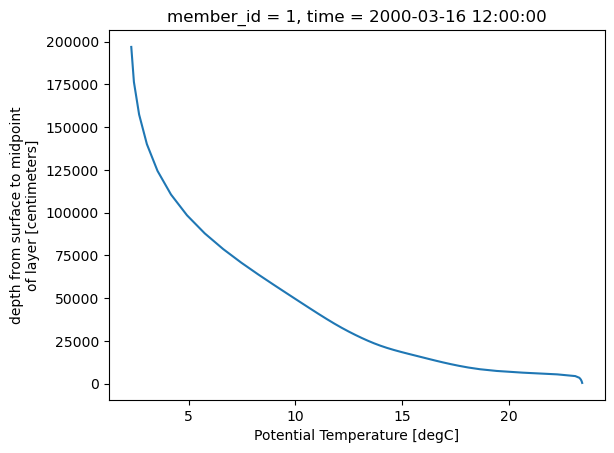

In [20]:
#this is only for one month
slice_time = ds_20C.sel(time = "2000-03")

slice_time

temp_2000 = slice_time.TEMP.sel(member_id = 1)

temp_2000

temp_2000_03 = temp_2000.isel(nlat = 90, nlon = 75)

temp_2000_03.plot(y = 'z_t')